In [2]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.io import wavfile
from pprint import pprint

In [3]:
# Abre o arquivo .wav
sample_rate, audio_data = wavfile.read('./../sinal 440Hz.wav', 'rb')

In [9]:
print(audio_data)

[ 0.          0.06262589  0.12503815 ... -0.18696209 -0.12503815
 -0.06262589]


In [4]:
# Verificar os dados
print(f"Taxa de amostragem: {sample_rate} Hz")
print(f"Formato dos dados: {audio_data.dtype}")
print(f"Número de canais: {audio_data.shape[1] if len(audio_data.shape) > 1 else 1}")
print(f"Duração: {len(audio_data) / sample_rate} s")


Taxa de amostragem: 44100 Hz
Formato dos dados: int16
Número de canais: 1
Duração: 5.0 s


In [5]:
# Se o áudio for estéreo (dois canais), vamos usar apenas um canal para simplificar
if len(audio_data.shape) > 1:
    audio_data = audio_data[:, 0]  # Pega o primeiro canal

# Normalizar o áudio para o intervalo [-1, 1] (boa prática)
audio_data = audio_data / np.max(np.abs(audio_data))

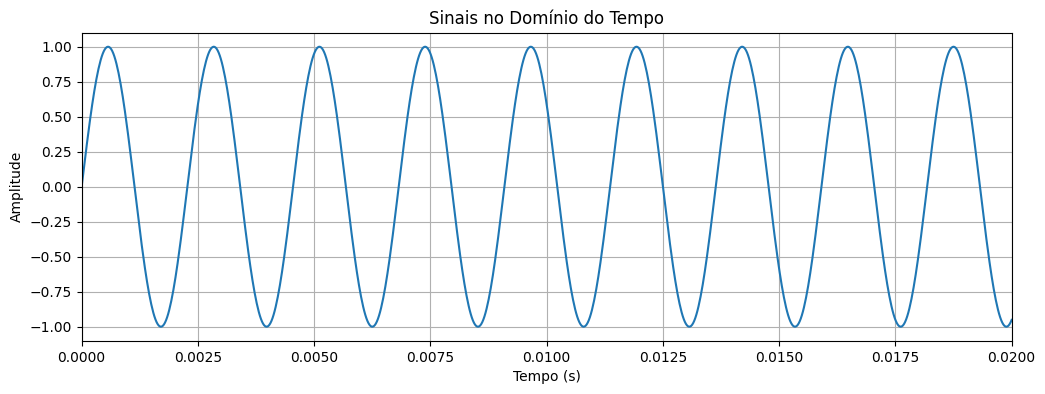

In [45]:
# Criar o vetor de tempo
time = np.linspace(0, len(audio_data) / sample_rate, num=len(audio_data))

def plot_signal(time, *audio_data_list, t_inicial=0, t_final=0.02, labels=None):
    """
    Plota um ou mais sinais no domínio do tempo em um intervalo especificado.

    Parâmetros:
    - time: numpy.ndarray, vetor de tempo.
    - *audio_data_list: lista de numpy.ndarray, dados dos sinais de áudio.
    - t_inicial: float, tempo inicial do intervalo de plotagem (padrão: 0).
    - t_final: float, tempo final do intervalo de plotagem (padrão: 0.02).
    - labels: lista de str, rótulos para os sinais (padrão: None).
    """
    plt.figure(figsize=(12, 4))
    for i, audio_data in enumerate(audio_data_list):
        label = labels[i] if labels and i < len(labels) else f'Sinal {i + 1}'
        plt.plot(time, audio_data, label=label)
    plt.title('Sinais no Domínio do Tempo')
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')
    plt.xlim(t_inicial, t_final)
    plt.grid(True)
    if labels:
        plt.legend()
    plt.show()

# Chamar a função para plotar o sinal
plot_signal(time, audio_data)


In [7]:
# Detecta os picos para identificar os ciclos do sinal
picos, _ = scipy.signal.find_peaks(audio_data, height=0)
print(picos)

[    25    125    226 ... 220224 220325 220425]


In [8]:
# Calcula o período (T) como a média dos intervalos entre picos consecutivos
T = np.mean(np.diff(picos)) / sample_rate
f = 1 / T
print(f"Período: {T:.6f} s")
print(f"Frequência: {f:.2f} Hz")

Período: 0.002273 s
Frequência: 440.00 Hz


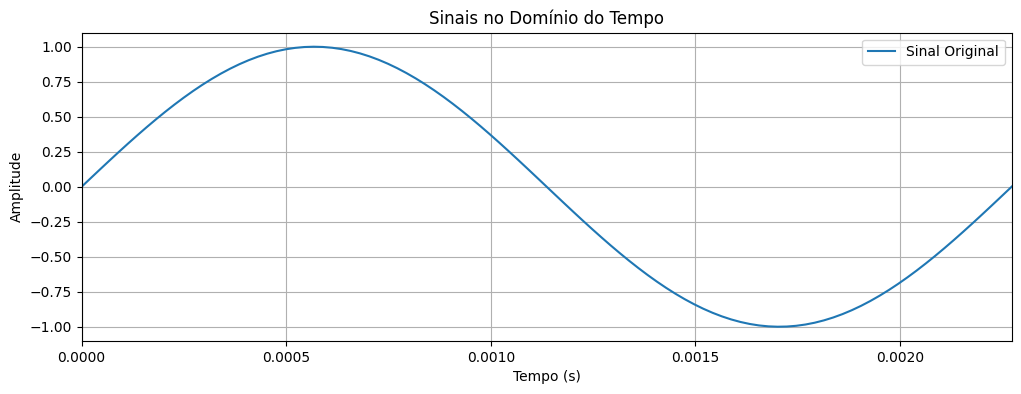

In [50]:
# Para realizar o cálculo, é importante utilizar os dados de um único período.
# Se 't' conter mais de um período, vamos restringir à primeira repetição.
t_um_periodo = time[:picos[1]]
sinal = audio_data[:picos[1]]

# Chamar a função para plotar o sinal
plot_signal(t_um_periodo, sinal, t_inicial=0, t_final=T, labels=['Sinal Original'])




In [15]:
# Determina o passo de tempo (assumindo espaçamento uniforme)
dt = time[1] - time[0]
print(f"Passo de tempo: {dt:.6f} s")

Passo de tempo: 0.000023 s


In [16]:
# Define o número de harmônicos que deseja considerar
n_harm = 10

In [21]:
# Cálculo dos coeficientes da Série de Fourier
# Atenção: as fórmulas abaixo seguem a convenção:
#   a₀ = (2/T) ∫₀ᵀ f(t) dt, 
#   aₙ = (2/T) ∫₀ᵀ f(t) cos(2πn t/T) dt,
#   bₙ = (2/T) ∫₀ᵀ f(t) sin(2πn t/T) dt,
# e a reconstrução: f(t) = a₀/2 + Σₙ [aₙ cos(2πn t/T) + bₙ sin(2πn t/T)]
a0 = 2 * np.trapezoid(audio_data, dx=dt) / T

# Vetores para armazenar os coeficientes
an = np.zeros(n_harm)
bn = np.zeros(n_harm)

print(f"a₀ = {a0:.6f}")
print(f"a = {an}")
print(f"b = {bn}")

a₀ = 0.000625
a = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
b = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
# Cálculo dos coeficientes para n = 1, 2, ..., n_harm
for n in range(1, n_harm + 1):
    an[n - 1] = 2 * np.trapezoid(audio_data * np.cos(2 * np.pi * n * time / T), dx=dt) / T
    bn[n - 1] = 2 * np.trapezoid(audio_data * np.sin(2 * np.pi * n * time / T), dx=dt) / T

    print(f"a{n} = {an[n - 1]:.6f}")
    print(f"b{n} = {bn[n - 1]:.6f}")

a1 = -53.268724
b1 = 2199.167237
a2 = 0.000120
b2 = 0.010395
a3 = 0.001300
b3 = -0.009316
a4 = 0.000255
b4 = 0.003756
a5 = 0.001315
b5 = -0.005732
a6 = 0.000177
b6 = 0.002991
a7 = 0.001285
b7 = -0.003935
a8 = 0.000305
b8 = 0.001540
a9 = 0.001247
b9 = -0.002912
a10 = 0.000071
b10 = 0.002126


In [59]:
# Reconstrução do sinal a partir dos coeficientes calculados
audio_reconstruido = np.full_like(audio_data, a0 / 2)
for n in range(1, n_harm + 1):
    audio_reconstruido += an[n - 1] * np.cos(2 * np.pi * n * time / T) + bn[n - 1] * np.sin(2 * np.pi * n * time / T)   

# Normalizar o áudio reconstruído para o intervalo [-1, 1] (boa prática)
audio_reconstruido = audio_reconstruido / np.max(np.abs(audio_reconstruido))

print(audio_reconstruido)

[-0.02421217  0.03846458  0.10098989 ... -0.16311496 -0.1009851
 -0.03845892]


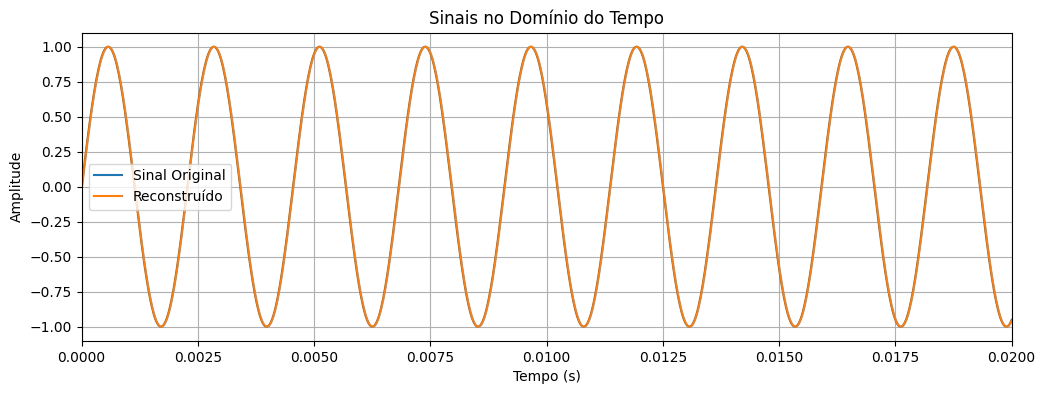

In [ ]:
# Plotar o sinal original e o reconstruído entre 0 e 0.02s
plot_signal(time, audio_data, audio_reconstruido, t_inicial=0,
            t_final=0.02, labels=['Sinal Original', 'Reconstruído'])

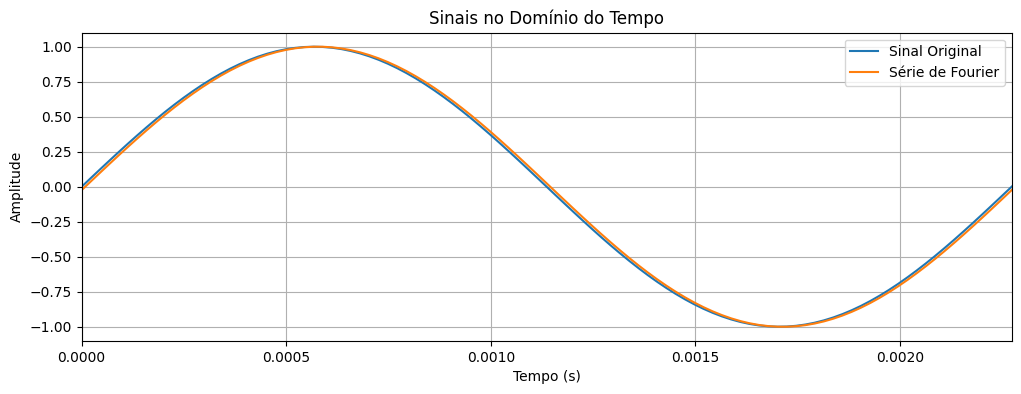

In [63]:
# Calcular a função Série de Fourier
def fourier_series(t, a0, an, bn, T):
    f = a0 / 2
    for n in range(1, len(an) + 1):
        f += an[n - 1] * np.cos(2 * np.pi * n * t / T) + \
            bn[n - 1] * np.sin(2 * np.pi * n * t / T)
    return f

# Calcular a função Série de Fourier para um período
f_serie_fourier = fourier_series(t_um_periodo, a0, an, bn, T)

# Normalizar a função Série de Fourier para o intervalo [-1, 1] (boa prática)
f_serie_fourier = f_serie_fourier / np.max(np.abs(f_serie_fourier))

# Plotar o sinal original e a função Série de Fourier entre 0 e 0.02s
plot_signal(t_um_periodo, sinal, f_serie_fourier, t_inicial=0,
            t_final=T, labels=['Sinal Original', 'Série de Fourier'])


In [ ]:
# Converter a Série de Fourier em notação LaTex
def fourier_series_latex(a0, an, bn, T):
    f = f'{a0:.6f} / 2'
    for n in range(1, len(an) + 1):
        f += f' + {an[n - 1]:.6f} \\cos\\left(\\frac{{2\\pi n t}}{{{T}}}\\right)'
        f += f' + {bn[n - 1]:.6f} \\sin\\left(\\frac{{2\\pi n t}}{{{T}}}\\right)'
    return f

# Exibir a função Série de Fourier em notação LaTex
print(fourier_series_latex(a0, an, bn, T))

0.000625 / 2 + -53.268724 \cos\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 2199.167237 \sin\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 0.000120 \cos\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 0.010395 \sin\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 0.001300 \cos\left(\frac{2\pi n t}{0.0022727296163273557}\right) + -0.009316 \sin\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 0.000255 \cos\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 0.003756 \sin\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 0.001315 \cos\left(\frac{2\pi n t}{0.0022727296163273557}\right) + -0.005732 \sin\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 0.000177 \cos\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 0.002991 \sin\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 0.001285 \cos\left(\frac{2\pi n t}{0.0022727296163273557}\right) + -0.003935 \sin\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 0.000305 \cos\left(\frac{2\pi n t}{0.00

In [66]:
# Renderizar a função Série de Fourier em notação LaTex
from IPython.display import display, Math
display(Math(fourier_series_latex(a0, an, bn, T)))

<IPython.core.display.Math object>

Vamos simplificar a função combinando os termos semelhantes.

**1. Termo Constante:**

$0.000625 / 2 = 0.0003125$

**2. Termos com cosseno:**

Agrupando os termos com $\cos\left(\frac{2\pi n t}{0.0022727296163273557}\right)$:

```
-53.268724 + 0.000120 + 0.001300 + 0.000255 + 0.001315 + 0.000177 + 0.001285 + 0.000305 + 0.001247 + 0.000071 = -53.26245
```

**3. Termos com seno:**

Agrupando os termos com $\sin\left(\frac{2\pi n t}{0.0022727296163273557}\right)$:

```
2199.167237 + 0.010395 - 0.009316 + 0.003756 - 0.005732 + 0.002991 - 0.003935 + 0.001540 - 0.002912 + 0.002126 = 2199.16617
```

**4. Substituindo na função original:**

Portanto, a função simplificada é:

$$
f(t) = 0.0003125 - 53.26245 \cos\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 2199.16617 \sin\left(\frac{2\pi n t}{0.0022727296163273557}\right)
$$

Podemos arredondar os coeficientes para facilitar a leitura:

$$
f(t) = 0.0003125 - 53.26245 \cos\left(87998.96 n t\right) + 2199.16617 \sin\left(87998.96 n t\right)
$$

**Resposta final:**

$f(t) = 0.0003125 - 53.26245 \cos\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 2199.16617 \sin\left(\frac{2\pi n t}{0.0022727296163273557}\right)$

Ou, aproximadamente:

$f(t) \approx 0.00031 - 53.262 \cos\left(87998.96 n t\right) + 2199.166 \sin\left(87998.96 n t\right)$


f(0.01) = 1335.772192


/tmp/ipykernel_26421/1803232335.py:22: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(t_inicial, t_final)


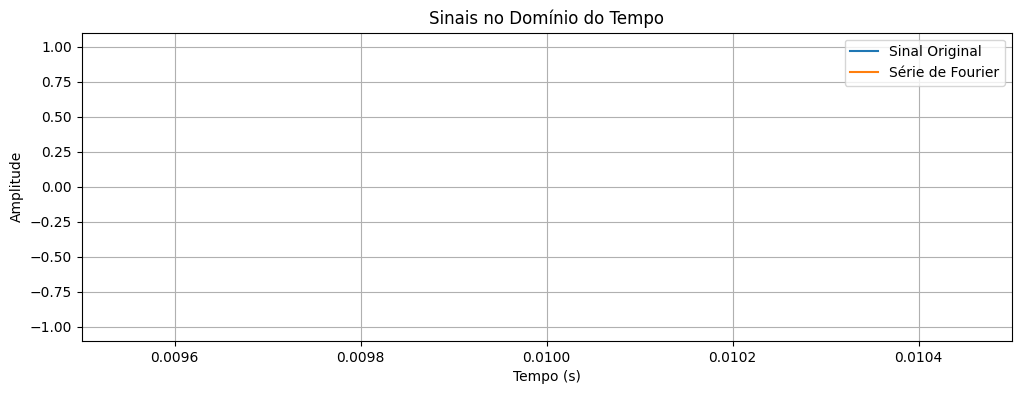

In [ ]:
# Dada a função Série de Fourier $f(t) = 0.0003125 - 53.26245 \cos\left(\frac{2\pi n t}{0.0022727296163273557}\right) + 2199.16617 \sin\left(\frac{2\pi n t}{0.0022727296163273557}\right)$, 
# podemos reconstruir o sinal original para qualquer instante de tempo $t$, no intervalo
# de 0s a 0.02s, por exemplo. Plotar o sinal original e a função Série de Fourier

plot_signal(t_um_periodo, sinal, f_serie_fourier, t_inicial=0, t_final=T, labels=['Sinal Original', 'Série de Fourier'])




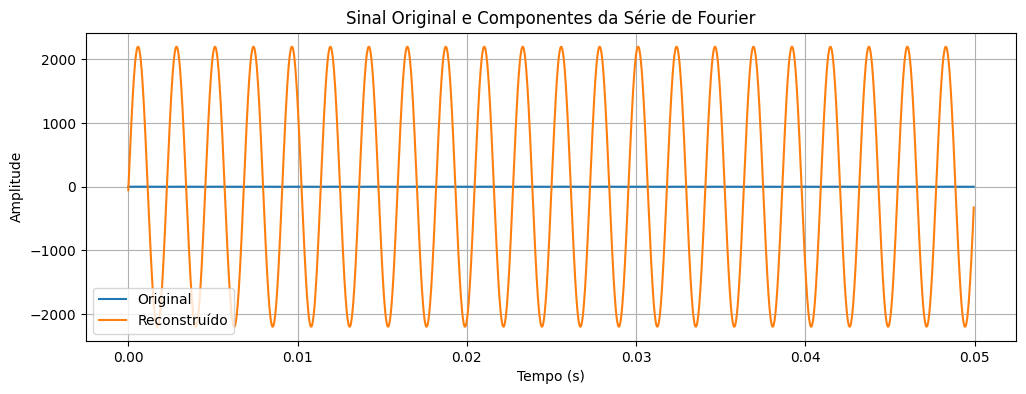

In [37]:
# Plotando o sinal f(t) = -53.27 \cos\left(\frac{2\pi n t}{T}\right) + 2199.16 \sin\left(\frac{2\pi n t}{T}\right)
# para n = 1, 2, ..., n_harm
# entre 0 e 0.01 segundos
i_inicial = int(0 / dt)
i_final = int(0.05 / dt)


plt.figure(figsize=(12, 4))
plt.plot(time[i_inicial:i_final], audio_data[i_inicial:i_final], label='Original')
plt.plot(time[i_inicial:i_final], audio_reconstruido[i_inicial:i_final], label='Reconstruído')

plt.title('Sinal Original e Componentes da Série de Fourier')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


